# Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gdax
%matplotlib inline  

In [2]:
import plotly.plotly as py
import plotly.graph_objs as go
import plotly

In [3]:
from datetime import datetime
from datetime import timedelta
import calendar

In [4]:
plotly.tools.set_credentials_file(username='gasia4444', api_key='rC8FB3pveGzyME366dL7')

# plotly.tools.set_credentials_file(username='gasia44', api_key='WquddqqfPKg5KJfPJFuk')

# GDAX to get BTC historical data

In [5]:
mod = gdax.PublicClient()
data = mod.get_product_historic_rates('BTC-USD')
df = pd.DataFrame(data, columns = ['time', 'low', 'high', 'open', 'close', 'volume'])
df = df.sort_values('time', ascending=True).reset_index(drop = True)

In [6]:
df.head()

,time,low,high,open,close,volume
0,1525602900,9548.00,9549.25,9548.00,9549.25,2.504208
1,1525602960,9549.25,9550.00,9549.25,9550.00,2.113413
2,1525603020,9549.99,9550.00,9550.00,9550.00,1.354326
3,1525603080,9549.99,9550.00,9549.99,9549.99,1.538041
4,1525603140,9549.99,9550.00,9549.99,9550.00,0.875965


# Analyze

In [7]:
import datetime
utc_time = datetime.datetime.utcfromtimestamp(np.min(df.time.values))

In [8]:
date_time = []
for i in df.time.values:
    utc_time = datetime.datetime.utcfromtimestamp(i)
    utc_time.strftime("%Y-%m-%d %H:%M:%S (UTC)")
    date_time.append(utc_time.strftime("%Y-%m-%d %H:%M:%S"))

In [9]:
df['timestamp'] = pd.to_datetime(date_time)
dd = df.set_index('timestamp')

In [10]:
dd.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 300 entries, 2018-05-06 10:35:00 to 2018-05-06 15:34:00
Data columns (total 6 columns):
time      300 non-null int64
low       300 non-null float64
high      300 non-null float64
open      300 non-null float64
close     300 non-null float64
volume    300 non-null float64
dtypes: float64(5), int64(1)
memory usage: 16.4 KB


In [11]:
dd = dd.drop('time', axis = 1)
dd = dd.drop('volume', axis = 1)

No handles with labels found to put in legend.


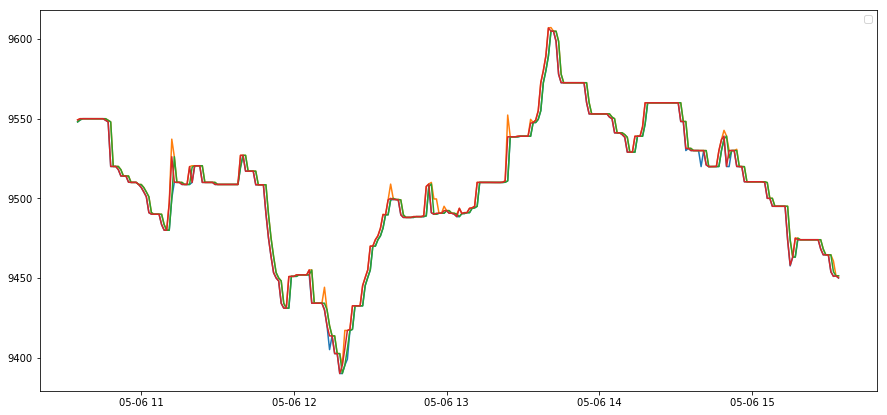

In [12]:
plt.figure(figsize = (15,7))
plt.plot(dd)
plt.legend()
plt.show()

In [13]:
dd.columns

Index(['low', 'high', 'open', 'close'], dtype='object')

In [14]:
data = [
       go.Scatter(
          x = dd.index,
          y = dd.low,
          mode='lines',
          name='low'),
    
        go.Scatter(
          x = dd.index,
          y = dd.high,
          mode='lines',
          name='high'),
    
        go.Scatter(
          x = dd.index,
          y = dd.open,
          mode='lines',
          name='open'),
    
        go.Scatter(
          x = dd.index,
          y = dd.close,
          mode='lines',
          name='close'),
    
    ]
py.iplot(data, filename = 'gasia')

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~gasia4444/0 or inside your plot.ly account where it is named 'gasia'


# Get a lot of data

In [15]:
class GDAX(object):
  """Class for fetching candle data for a given currency pair."""

  def __init__(self, pair):
    """Create the exchange object.
    Args:
      pair (str): Examples: 'BTC-USD', 'ETH-USD'...
    """
    self.pair = pair
    self.uri = 'https://api.gdax.com/products/{pair}/candles'.format(pair=self.pair)

  @staticmethod
  def __date_to_iso8601(date):
    """Convert a datetime object to the ISO-8601 date format (expected by the GDAX API).
    Args:
      date (datetime): The date to be converted.
    Returns:
      str: The ISO-8601 formatted date.
    """
    return '{year}-{month:02d}-{day:02d}T{hour:02d}:{minute:02d}:{second:02d}'.format(
        year=date.year,
        month=date.month,
        day=date.day,
        hour=date.hour,
        minute=date.minute,
        second=date.second)

  def request_slice(self, start, end, granularity):
    # Allow 3 retries (we might get rate limited).
    retries = 3
    for retry_count in xrange(0, retries):
      # From https://docs.gdax.com/#get-historic-rates the response is in the format:
      # [[time, low, high, open, close, volume], ...]
      response = requests.get(self.uri, {
        'start': GDAX.__date_to_iso8601(start),
        'end': GDAX.__date_to_iso8601(end),
        'granularity': granularity * 60  # GDAX API granularity is in seconds.
      })

      if response.status_code != 200 or not len(response.json()):
        if retry_count + 1 == retries:
          raise Exception('Failed to get exchange data for ({}, {})!'.format(start, end))
        else:
          # Exponential back-off.
          sleep(1.5 ** retry_count)
      else:
        # Sort the historic rates (in ascending order) based on the timestamp.
        result = sorted(response.json(), key=lambda x: x[0])
        return result

  def fetch(self, start, end, granularity):
    """Fetch the candle data for a given range and granularity.
    Args:
      start (datetime): The start of the date range.
      end (datetime): The end of the date range (excluded).
      granularity (int): The granularity of the candles data (in minutes).
    Returns:
      (pandas.DataFrame): A data frame of the OHLC and volume information, indexed by their unix timestamp.
    """
    data = []

    # We will fetch the candle data in windows of maximum 100 items.
    # GDAX has a limit of returning maximum of 200, per request.
    delta = timedelta(minutes=granularity * 100)

    slice_start = start
    while slice_start != end:
      slice_end = min(slice_start + delta, end)
      data += self.request_slice(slice_start, slice_end, granularity)
      slice_start = slice_end

    data_frame = pandas.DataFrame(data=data, columns=['time', 'low', 'high', 'open', 'close', 'volume'])
    data_frame.set_index('time', inplace=True)
    return data_frame

In [17]:
from tqdm import tqdm, tqdm_notebook

In [21]:
end = pd.to_datetime('2018-05-01 00:00:00')
for_until = pd.to_datetime('2018-05-02 00:00:00')
all_data =[]
mod = gdax.PublicClient()
# for_until_unix = calendar.timegm(for_until.utctimetuple())
# tq = for_until_unix - calendar.timegm(end.utctimetuple())

ee = (for_until - end) 
pbar = tqdm_notebook(total = (ee.days*24)//(3) )

while end + timedelta(hours = 3) < for_until:
    pbar.update(1)
    
    start = end 
    end  = start + timedelta(hours = 3)
    mod = gdax.PublicClient()
    data = mod.get_product_historic_rates('BTC-USD', start = start, end = end, granularity='60' )
    all_data.extend(data)
    
    
pbar.close()   

HBox(children=(IntProgress(value=0, max=8), HTML(value='')))

In [ ]:
# ?mod.get_product_historic_rates

In [23]:
qq = [i for i in all_data if len(i) == 6]
df = pd.DataFrame(qq, columns = ['time', 'low', 'high', 'open', 'close', 'volume'])
# df = df.sort_values('time', ascending=True).reset_index(drop = True)

In [24]:
date_time = []
for i in df.time.values:
    utc_time = datetime.datetime.utcfromtimestamp(i)
#     utc_time.strftime("%Y-%m-%d %H:%M:%S (UTC)")
    date_time.append(utc_time.strftime("%Y-%m-%d %H:%M:%S"))

In [25]:
df['timestamp'] = pd.to_datetime(date_time)
dd = df.set_index('timestamp')

In [27]:
dd.head()

,time,low,high,open,close,volume
timestamp,,,,,,
2018-05-01 02:59:00,1525143540,9007.00,9031.25,9031.24,9007.00,45.595921
2018-05-01 02:58:00,1525143480,9029.80,9031.25,9029.80,9031.25,4.930861
2018-05-01 02:57:00,1525143420,9025.94,9029.80,9025.94,9029.80,7.969799
2018-05-01 02:56:00,1525143360,9025.93,9025.94,9025.94,9025.94,1.767981
2018-05-01 02:55:00,1525143300,9025.93,9025.94,9025.94,9025.94,1.530862


In [28]:
dd= dd.drop_duplicates()
dd.sort_index(inplace=True)

# CHANGE THE NAME 

In [29]:
name = 'bitcoin_data_one_minute.csv'
dd.to_csv(name)
df = pd.read_csv(name, parse_dates = ['timestamp']).set_index('timestamp')

# RUN UNTIL HERE

### append the new scraped data to the old one

In [29]:
# dd_new = dd.copy()
# merged_data = pd.concat([df, dd_new])
# merged_data.drop_duplicates(inplace=True)
# merged_data = merged_data.sort_index()
# merged_data.to_csv('bitcoin_data.csv')

# Read Data

In [30]:
df = pd.read_csv('bitcoin_data_1.csv', parse_dates = ['timestamp']).set_index('timestamp')

In [31]:
df.sort_index(inplace=True)

In [33]:
dd = df
data = [
       go.Scatter(
          x = dd.index,
          y = dd.low,
          mode='lines',
          name='low'),
    
        go.Scatter(
          x = dd.index,
          y = dd.high,
          mode='lines',
          name='high'),
    
        go.Scatter(
          x = dd.index,
          y = dd.open,
          mode='lines',
          name='open'),
    
        go.Scatter(
          x = dd.index,
          y = dd.close,
          mode='lines',
          name='close'),
    
        go.Scatter(
          x = dd.index,
          y = dd.volume,
          mode='lines',
          name='volume'),
    
    ]
py.iplot(data, filename = 'gasia')

/home/gasia/anaconda3/lib/python3.6/site-packages/plotly/plotly/plotly.py:224: UserWarning:

Woah there! Look at all those points! Due to browser limitations, the Plotly SVG drawing functions have a hard time graphing more than 500k data points for line charts, or 40k points for other types of charts. Here are some suggestions:
(1) Use the `plotly.graph_objs.Scattergl` trace object to generate a WebGl graph.
(2) Trying using the image API to return an image instead of a graph URL
(3) Use matplotlib
(4) See if you can create your visualization with fewer data points

If the visualization you're using aggregates points (e.g., box plot, histogram, etc.) you can disregard this warning.



High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~gasia4444/0 or inside your plot.ly account where it is named 'gasia'


/home/gasia/anaconda3/lib/python3.6/site-packages/plotly/api/v1/clientresp.py:40: UserWarning:

Estimated Draw Time Too Long



In [34]:
dd = dd.drop('time', axis = 1)

In [35]:
dd.head()

,low,high,open,close,volume
timestamp,,,,,
2015-01-08 01:20:00,360.00,360.00,360.00,360.00,0.01
2015-01-08 01:25:00,271.60,344.67,271.84,344.67,0.06
2015-01-08 01:30:00,270.35,346.41,346.41,321.98,0.13
2015-01-08 01:35:00,281.36,349.67,302.25,341.35,0.11
2015-01-08 01:40:00,273.20,351.38,348.77,351.38,0.11


take the mean of low, high, open, close

In [36]:
df = pd.DataFrame(dd[['low', 'high', 'open', 'close']].mean(axis=1), columns=['data'])

In [37]:
df['volume'] = dd['volume']

In [38]:
#df = pd.DataFrame(dd[['close', 'volume']])

In [39]:
df.head()

,data,volume
timestamp,,
2015-01-08 01:20:00,360.0000,0.01
2015-01-08 01:25:00,308.1950,0.06
2015-01-08 01:30:00,321.2875,0.13
2015-01-08 01:35:00,318.6575,0.11
2015-01-08 01:40:00,331.1825,0.11


-----------------

percentage change, to detect interesting events

In [40]:
change = pd.DataFrame(df.data.pct_change(1))
change.columns = ['percent_change']
change.dropna(inplace=True)

In [41]:
data = [go.Histogram(x=change.percent_change.values)]
py.iplot(data, filename='histogram')

/home/gasia/anaconda3/lib/python3.6/site-packages/plotly/plotly/plotly.py:224: UserWarning:

Woah there! Look at all those points! Due to browser limitations, the Plotly SVG drawing functions have a hard time graphing more than 500k data points for line charts, or 40k points for other types of charts. Here are some suggestions:
(1) Use the `plotly.graph_objs.Scattergl` trace object to generate a WebGl graph.
(2) Trying using the image API to return an image instead of a graph URL
(3) Use matplotlib
(4) See if you can create your visualization with fewer data points

If the visualization you're using aggregates points (e.g., box plot, histogram, etc.) you can disregard this warning.



In [38]:
# dd = df
# data = [
#        go.Scatter(
#           x = dd.index,
#           y = dd.data,
#           mode='lines',
#           name='data'),
    
#     ]
# py.iplot(data, filename = 'gasia')

In [39]:
spikes = change[np.abs(change.percent_change)>=0.05]

In [40]:
temp = pd.DataFrame(df['data'].rolling(5000).mean().dropna())

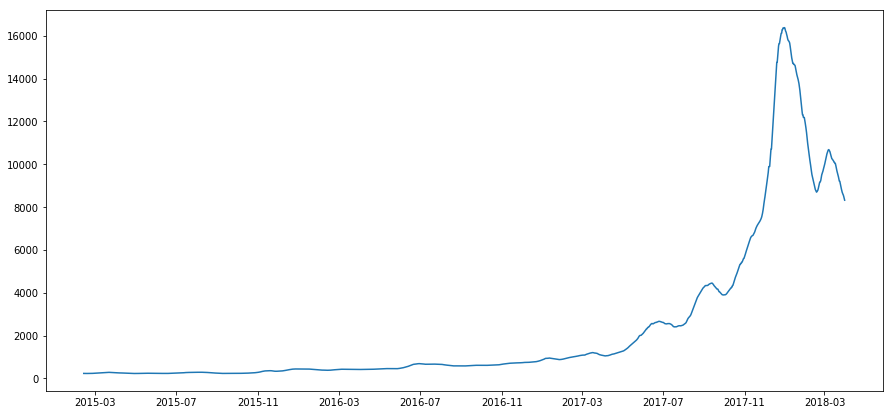

In [41]:
plt.figure(figsize=(15,7))
plt.plot(temp)

In [43]:
# import numpy as np
# from scipy.signal import find_peaks_cwt
# indexes = find_peaks_cwt(df.data.values, np.arange(1, 550))

In [44]:
# find_peaks_df = df.iloc[indexes]

In [45]:
# data = [

#         go.Scatter(
#           x = df.index,
#           y = df.data,
#           mode='lines',
#           name='data'),
#         go.Scatter(
#           x = find_peaks_df.index,
#           y = find_peaks_df.data,
#           mode='markers',
#           name='min_max'),
    
#     ]

# py.iplot(data, filename = 'gasia')

In [46]:
import sys
from numpy import NaN, Inf, arange, isscalar, asarray, array

def peakdet(v, delta, x = None):
    """
    Converted from MATLAB script at http://billauer.co.il/peakdet.html
    
    Returns two arrays
    
    function [maxtab, mintab]=peakdet(v, delta, x)
    %PEAKDET Detect peaks in a vector
    %        [MAXTAB, MINTAB] = PEAKDET(V, DELTA) finds the local
    %        maxima and minima ("peaks") in the vector V.
    %        MAXTAB and MINTAB consists of two columns. Column 1
    %        contains indices in V, and column 2 the found values.
    %      
    %        With [MAXTAB, MINTAB] = PEAKDET(V, DELTA, X) the indices
    %        in MAXTAB and MINTAB are replaced with the corresponding
    %        X-values.
    %
    %        A point is considered a maximum peak if it has the maximal
    %        value, and was preceded (to the left) by a value lower by
    %        DELTA.
    
    % Eli Billauer, 3.4.05 (Explicitly not copyrighted).
    % This function is released to the public domain; Any use is allowed.
    
    """
    maxtab = []
    mintab = []
       
    if x is None:
        x = arange(len(v))
    
    v = asarray(v)
    
    if len(v) != len(x):
        sys.exit('Input vectors v and x must have same length')
    
    if not isscalar(delta):
        sys.exit('Input argument delta must be a scalar')
    
    if delta <= 0:
        sys.exit('Input argument delta must be positive')
    
    mn, mx = Inf, -Inf
    mnpos, mxpos = NaN, NaN
    
    lookformax = True
    
    for i in arange(len(v)):
        this = v[i]
        if this > mx:
            mx = this
            mxpos = x[i]
        if this < mn:
            mn = this
            mnpos = x[i]
        
        if lookformax:
            if this < mx-delta:
                maxtab.append((mxpos, mx))
                mn = this
                mnpos = x[i]
                lookformax = False
        else:
            if this > mn+delta:
                mintab.append((mnpos, mn))
                mx = this
                mxpos = x[i]
                lookformax = True

    return array(maxtab), array(mintab)

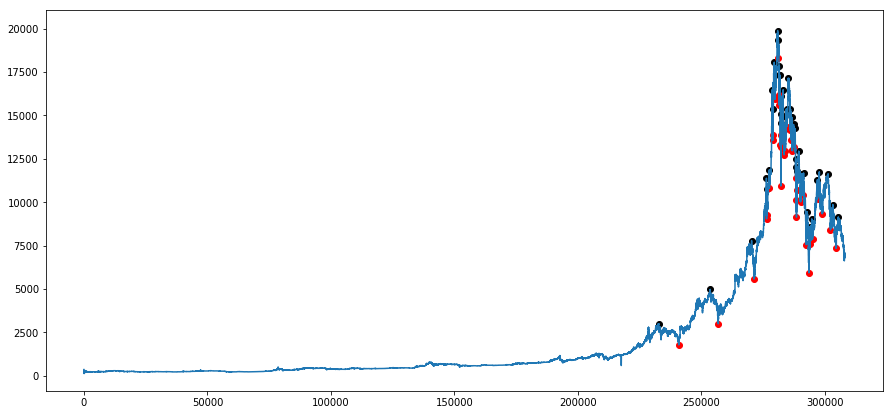

In [47]:
from matplotlib.pyplot import plot, scatter, show, figure
# series = [0,0,0,2,0,0,0,-2,0,0,0,2,0,0,0,-2,0]
series = df.data.values.tolist()
maxtab, mintab = peakdet(series,1000)
figure(figsize = (15,7))
plot(series)
scatter(array(maxtab)[:,0], array(maxtab)[:,1], color='black')
scatter(array(mintab)[:,0], array(mintab)[:,1], color='red')
show()

In [48]:
# pd.DataFrame(df.iloc[array(maxtab)[:,0]].data , index=df.iloc[array(maxtab)[:,0]].index).to_csv('max_btc.csv')
# pd.DataFrame(df.iloc[array(mintab)[:,0]].data , index=df.iloc[array(mintab)[:,0]].index).to_csv('min_btc.csv')

In [50]:
data = [

        go.Scatter(
          x = df.index,
          y = df.data,
          mode='lines',
          name='data'),
        go.Scatter(
          x = df.iloc[array(maxtab)[:,0]].index,
          y = df.iloc[array(maxtab)[:,0]].data,
          mode='markers',
          name='max'),
    
            go.Scatter(
          x = df.iloc[array(mintab)[:,0]].index,
          y = df.iloc[array(mintab)[:,0]].data,
          mode='markers',
          name='min'),
    
    ]

py.iplot(data, filename = 'gasia')

/home/gasia/anaconda3/lib/python3.6/site-packages/plotly/plotly/plotly.py:224: UserWarning:

Woah there! Look at all those points! Due to browser limitations, the Plotly SVG drawing functions have a hard time graphing more than 500k data points for line charts, or 40k points for other types of charts. Here are some suggestions:
(1) Use the `plotly.graph_objs.Scattergl` trace object to generate a WebGl graph.
(2) Trying using the image API to return an image instead of a graph URL
(3) Use matplotlib
(4) See if you can create your visualization with fewer data points

If the visualization you're using aggregates points (e.g., box plot, histogram, etc.) you can disregard this warning.



High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~gasia4444/0 or inside your plot.ly account where it is named 'gasia'


/home/gasia/anaconda3/lib/python3.6/site-packages/plotly/api/v1/clientresp.py:40: UserWarning:

Estimated Draw Time Too Long



In [51]:
np.corrcoef(df.volume.values[1:], change.percent_change.values)

array([[ 1.        , -0.04629808],
       [-0.04629808,  1.        ]])

In [52]:
df.head()

,data,volume
timestamp,,
2015-01-08 01:20:00,360.0000,0.01
2015-01-08 01:25:00,308.1950,0.06
2015-01-08 01:30:00,321.2875,0.13
2015-01-08 01:35:00,318.6575,0.11
2015-01-08 01:40:00,331.1825,0.11


In [53]:
data = [
       go.Scatter(
          x = df.index,
          y = df.close,
          mode='lines',
          name='low'),
    
        go.Scatter(
          x = spikes.index,
          y = df.loc[spikes.index].close,
          mode='markers',
          name='close'),
    
        go.Scatter(
          x = dd.index,
          y = dd.volume*10,
          mode='lines',
          name='volume'),
    
    ]
py.iplot(data, filename = 'gasia')

AttributeError: 'DataFrame' object has no attribute 'close'

In [ ]:
# spikes.to_csv("spike_price_change.csv")

In [ ]:
data = [
       go.Scatter(
          x = dd.index,
          y = dd.low,
          mode='lines',
          name='low'),
    
        go.Scatter(
          x = dd.index,
          y = dd.high,
          mode='lines',
          name='high'),
    
        go.Scatter(
          x = dd.index,
          y = dd.open,
          mode='lines',
          name='open'),
    
        go.Scatter(
          x = dd.index,
          y = dd.close,
          mode='lines',
          name='close'),
    
        go.Scatter(
          x = dd.index,
          y = dd.volume*10,
          mode='lines',
          name='volume'),
    
    ]
py.iplot(data, filename = 'gasia')

In [ ]:
dif = df.diff(1)

In [ ]:
dif.dropna(inplace=True)

In [ ]:
# take ratio

In [ ]:
data = [
       go.Scatter(
          x = df.index,
          y = np.log(df.close),
          mode='lines',
          name='dif'),
    
    
    ]
py.iplot(data, filename = 'gasia')

In [ ]:
data = [
       go.Scatter(
          x = dif.index,
          y = dif.close,
          mode='lines',
          name='dif'),
    
    ]
py.iplot(data, filename = 'gasia')

In [28]:
x = dif.close.values
data = [go.Histogram(x=x)]

py.iplot(data, filename='basic histogram')

/home/gasia/anaconda3/lib/python3.6/site-packages/plotly/plotly/plotly.py:236: UserWarning:

Woah there! Look at all those points! Due to browser limitations, the Plotly SVG drawing functions have a hard time graphing more than 500k data points for line charts, or 40k points for other types of charts. Here are some suggestions:
(1) Use the `plotly.graph_objs.Scattergl` trace object to generate a WebGl graph.
(2) Trying using the image API to return an image instead of a graph URL
(3) Use matplotlib
(4) See if you can create your visualization with fewer data points

If the visualization you're using aggregates points (e.g., box plot, histogram, etc.) you can disregard this warning.



In [29]:
data = [go.Histogram(x=x,
                     cumulative=dict(enabled=True))]

py.iplot(data, filename='cumulative histogram')

/home/gasia/anaconda3/lib/python3.6/site-packages/plotly/plotly/plotly.py:236: UserWarning:

Woah there! Look at all those points! Due to browser limitations, the Plotly SVG drawing functions have a hard time graphing more than 500k data points for line charts, or 40k points for other types of charts. Here are some suggestions:
(1) Use the `plotly.graph_objs.Scattergl` trace object to generate a WebGl graph.
(2) Trying using the image API to return an image instead of a graph URL
(3) Use matplotlib
(4) See if you can create your visualization with fewer data points

If the visualization you're using aggregates points (e.g., box plot, histogram, etc.) you can disregard this warning.



(array([  1.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          1.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   1.00000000e+00,   1.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   1.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
        

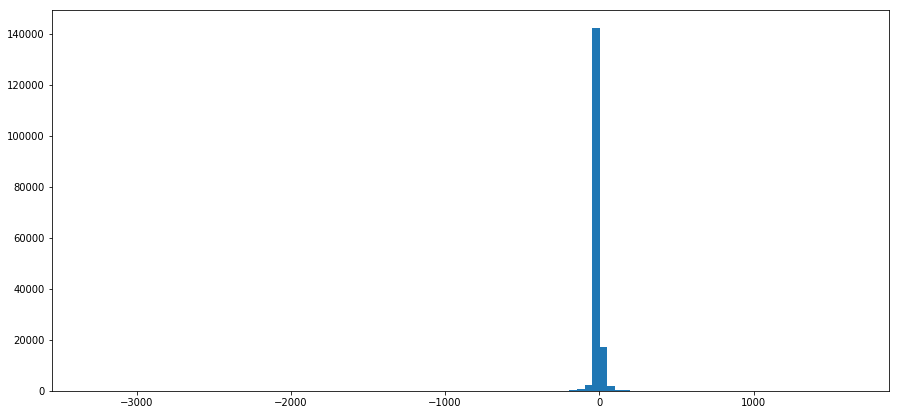

In [30]:
plt.figure(figsize=(15,7))
plt.hist(dif.close.values, bins =100)